# Feature Engineering 

In [1]:
%reset -f
import pandas as pd
import numpy as np

from xgboost import XGBClassifier
#import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import re, sqlite3, pickle, time, datetime, random, sys
# sys.path is a list of absolute path strings
sys.path.append('/home/d/dlr10/Documents/02_Statitics_modelling/0_FunctionsScripts')
import Loading_Data_Functions as load_fn
import FineTuning_Functions as FineTuning
import Learning_Curves_Functions as LearningCurves

pd.options.display.float_format = '{:,.5f}'.format

import matplotlib
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['mathtext.fontset'] = 'cm'
#matplotlib.rcParams['mathtext.fontset'] = 'cm'

2023-08-17 10:18:35.831077: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/local/apps/gcc/8.2.0/lib:/cm/local/apps/gcc/8.2.0/lib64:/cm/local/apps/torque/6.1.3/lib
2023-08-17 10:18:35.831122: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# 0. Load Data
* https://www.reneshbedre.com/blog/anova.html

In [2]:
path = r'/home/d/dlr10/Documents/02_Statitics_modelling/DataSets/'

t = time.time()
timeSeries      = False
peakstroughs    = False
samp_to_extract = 0
df_patients, df_admissions, df_eobs = load_fn.Load_data(years = '2019_2020')
#X_data       = load_fn.Exctract_Xdata(df_patients, df_admissions, df_eobs, samp_to_extract, peakstroughs, timeSeries  )

X_data = pickle.load(open(path + 'df_first_2019_20.pickle','rb'))
print("Elapsed time:", time.time()-t)

Elapsed time: 13.124222755432129


In [3]:
len(X_data['admission_id'])

7892

In [8]:
len(df_admissions[df_admissions['admission_id'].isin(X_data['admission_id'])]['patient_id'].unique())

7236

In [4]:
X_data.head(4)

,admission_id,rr,ews,heart_rate,temperature,sbp,dbp,Oxygen_Saturation,Assisted_O2,Confusion,...,ALB,ALP,BILI,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin,Mortality
0,70461223,17.00000,2,102.00000,36.50000,148.00000,80.00000,95.00000,0.00000,0,...,34.00000,69.00000,8.00000,1,0,69,0,1,1.00000,0
144,19488170,22.00000,7,95.00000,39.80000,113.00000,68.00000,96.00000,1.00000,0,...,40.00000,152.00000,13.00000,-1,0,77,2,1,0.00000,0
288,89219346,17.00000,0,69.00000,37.20000,148.00000,83.00000,99.00000,0.00000,0,...,27.00000,93.00000,1.99850,-1,9,60,2,0,1.00000,1
432,18991471,33.00000,10,129.00000,37.90000,80.00000,59.00000,97.00000,1.00000,0,...,36.00000,200.00000,50.00000,-1,0,74,0,1,1.00000,1


In [5]:
feat_list = X_data.columns.tolist()
feat_list = feat_list[1:-1]
print(feat_list)
print("Number of features:",len(feat_list))

['rr', 'ews', 'heart_rate', 'temperature', 'sbp', 'dbp', 'Oxygen_Saturation', 'Assisted_O2', 'Confusion', 'CREA', 'UREA', 'K', 'GFR', 'WBC', 'PLT', 'HCT', 'HGB', 'RBC', 'MCH', 'MCV', 'NEUAB', 'TLYMAB', 'EOSAB', 'MONAB', 'BASAB', 'ALB', 'ALP', 'BILI', 'sex', 'ethnicity', 'age_at_admin', 'Comorb_score', 'Spcfc_Comorb', 'had_Prev_admin']
Number of features: 34


In [6]:
# Loading the CSV with types
data_types = pd.read_csv('csv_Type_variables.csv')
# Dictionary of features and types
data_types = data_types.set_index('Variable').to_dict()['Type']

# 1. Multicollinearity
* [Link to the example code](https://towardsdatascience.com/multi-collinearity-in-regression-fe7a2c1467ea)
* [Link to Multi-Collinearity: brief description](https://www.britannica.com/topic/collinearity-statistics)
* [Link to Multicollinearity analysis](https://statisticsbyjim.com/regression/multicollinearity-in-regression-analysis/)
* [Link to Multicollinearity and LogReg, SVM, and random Forest](https://medium.com/@raj5287/effects-of-multi-collinearity-in-logistic-regression-svm-rf-af6766d91f1b)

In [7]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [8]:
def calc_variance_inflation_factor(X_in,feat_list):
    # VIF dataframe
    X = X_in[feat_list]
    vif_data = pd.DataFrame()
    vif_data["feature"] = feat_list

    # calculating VIF for each feature
    vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                              for i in range(len(X.columns))]
    print("VARIANCE INFLATION FACTOR TO ASSES MULTICOLLINEARITY")
    display(vif_data.sort_values(by='VIF', ascending=False))
    return (vif_data)

In [9]:
# Measuring multicollinearity using 
# the independent variables set
sel_feat_list = feat_list.copy()
vif_data = calc_variance_inflation_factor(X_data, sel_feat_list)
######
# Removing features with high collinearity to assess its impact
######
sel_feat_list.remove('temperature')
sel_feat_list.remove('Oxygen_Saturation')
sel_feat_list.remove('ews')
sel_feat_list.remove('rr')
sel_feat_list.remove('age_at_admin')
vif_data = calc_variance_inflation_factor(X_data, sel_feat_list)


VARIANCE INFLATION FACTOR TO ASSES MULTICOLLINEARITY


,feature,VIF
19,MCV,"6,527.56704"
15,HCT,"6,349.75771"
18,MCH,"6,042.56509"
16,HGB,"6,027.06805"
3,temperature,"1,314.54073"
17,RBC,"1,189.38097"
6,Oxygen_Saturation,945.42606
25,ALB,76.18022
4,sbp,52.09155
12,GFR,50.36894


VARIANCE INFLATION FACTOR TO ASSES MULTICOLLINEARITY


,feature,VIF
12,HGB,"6,012.20507"
14,MCH,"5,990.40057"
15,MCV,"5,952.03359"
11,HCT,"5,710.83606"
13,RBC,338.80918
21,ALB,73.61688
1,sbp,45.65599
7,K,44.67456
8,GFR,43.90550
2,dbp,37.21602


Sholud we normalised encoded data?

[Normalised Encoding Data](https://datascience.stackexchange.com/questions/56142/how-can-i-use-mean-normalization-should-i-use-it-for-numerical-columns-or-categ)

[Encoding Data](https://towardsdatascience.com/categorical-feature-encoding-547707acf4e5#b398)


In [10]:
# Normalise Data
X_data_feat = X_data[feat_list]
X_data_norm = (X_data_feat-X_data_feat.mean())/X_data_feat.std()
X_data_norm.head(4)

,rr,ews,heart_rate,temperature,sbp,dbp,Oxygen_Saturation,Assisted_O2,Confusion,CREA,...,BASAB,ALB,ALP,BILI,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin
0,-0.89879,-0.64487,0.58016,-0.58936,0.85712,0.33852,-0.24049,-0.84547,-0.29069,-0.54345,...,-0.33671,-0.99812,-0.74126,-0.56254,1.10842,-0.42599,-0.11806,-1.02865,1.01784,0.93038
144,0.09979,1.10752,0.23891,3.02557,-0.63917,-0.41824,0.06618,1.18263,-0.29069,0.01102,...,-0.61691,0.13588,1.14153,-0.05852,-0.90207,-0.42599,0.37311,0.06176,1.01784,-1.07469
288,-0.89879,-1.34582,-1.02858,0.17745,0.85712,0.52770,0.98622,-0.84547,-0.29069,1.79767,...,-0.80371,-2.32112,-0.19684,-1.16751,-0.90207,3.22035,-0.67063,0.06176,-0.98235,0.93038
432,2.29667,2.15895,1.89640,0.94425,-2.04995,-0.98580,0.37286,1.18263,-0.29069,1.33561,...,0.22371,-0.62012,2.23037,3.67122,-0.90207,-0.42599,0.18892,-1.02865,1.01784,0.93038


In [11]:
############################################################
# ENCODING CATEGORICAL VARIABLES WITH TARGET ENCODER
# https://towardsdatascience.com/target-encoding-and-bayesian-target-encoding-5c6a6c58ae8c
############################################################
def target_encoder_Binary(column, target, X_data):
    df = []
    for cat in X_data[column].unique():
        row = []
        row.append(len(X_data[(X_data[target]==0) & (X_data[column] == cat)]))
        row.append(len(X_data[(X_data[target]==1) & (X_data[column] == cat)]))
        df.append(row)
    df = pd.DataFrame(df, index = X_data[column].unique(), columns = ['0','1'])
    df['prob'] = df['1']/(df['1']+df['0'])
    col_encod = X_data[column].map(dict(zip(df.index, df['prob'])))
    return col_encod
############################################################
X_data_norm_2 = pd.DataFrame()
for feat in feat_list:
    if data_types[feat] == 'Continuous':
        X_data_feat = X_data[feat]
        X_data_norm_2[feat] = (X_data_feat-X_data_feat.mean())/X_data_feat.std()
    elif data_types[feat] == 'Categorical':
        X_data_norm_2[feat] = target_encoder_Binary(feat, 'Mortality', X_data)
    elif data_types[feat] == 'Binary':
        X_data_norm_2[feat] = X_data[feat].copy()
        
X_data_norm = X_data_norm_2.copy()
X_data_norm.head(4)


,rr,ews,heart_rate,temperature,sbp,dbp,Oxygen_Saturation,Assisted_O2,Confusion,CREA,...,BASAB,ALB,ALP,BILI,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin
0,-0.89879,0.25447,0.58016,-0.58936,0.85712,0.33852,-0.24049,0.00000,0,-0.54345,...,-0.33671,-0.99812,-0.74126,-0.56254,1,0.25481,-0.11806,-1.02865,1,1.00000
144,0.09979,0.27203,0.23891,3.02557,-0.63917,-0.41824,0.06618,1.00000,0,0.01102,...,-0.61691,0.13588,1.14153,-0.05852,-1,0.25481,0.37311,0.06176,1,0.00000
288,-0.89879,0.22719,-1.02858,0.17745,0.85712,0.52770,0.98622,0.00000,0,1.79767,...,-0.80371,-2.32112,-0.19684,-1.16751,-1,0.27778,-0.67063,0.06176,0,1.00000
432,2.29667,0.23529,1.89640,0.94425,-2.04995,-0.98580,0.37286,1.00000,0,1.33561,...,0.22371,-0.62012,2.23037,3.67122,-1,0.25481,0.18892,-1.02865,1,1.00000


In [12]:
#####################################
# Measuring multicollinearity using 
# the independent variables set
sel_feat_list = feat_list.copy()
vif_data      = calc_variance_inflation_factor(X_data_norm, sel_feat_list)

VARIANCE INFLATION FACTOR TO ASSES MULTICOLLINEARITY


,feature,VIF
15,HCT,192.51969
16,HGB,187.94070
18,MCH,60.44202
17,RBC,52.89335
19,MCV,52.57866
1,ews,49.99858
29,ethnicity,48.80985
9,CREA,6.57680
12,GFR,6.09511
13,WBC,5.83901


# 2. Feature correlation

* Two continuos variables spearman coefficient [-1,1]
* Two Categorical variables Cramer'sV coeeficient [0,1]
* A categorical variable witha  contionuous variables Point biseral correlation [-1,1]

In [13]:
from scipy import stats

In [14]:
########################################################################
# FUNCTION TO DETERMINE THE CORRELATION DEPENDING ON TYPE OF VARIABLES
########################################################################
def correlation_dependednt_type(X_data, feat1, type1, feat2, type2):
    serie1 = X_data[feat1].tolist()
    serie2 = X_data[feat2].tolist()
    type1 = type1 if (type1 == 'Continuous' or type1 == 'Categorical') else 'Categorical'
    type2 = type2 if (type2 == 'Continuous' or type2 == 'Categorical') else 'Categorical'    
    # Spearman correlation for two continuous variables
    if (type1 == 'Continuous') and (type2 == 'Continuous'):
        coef, p = stats.spearmanr(serie1, serie2)
    # Cramer'sV correlation for two categorical variables
    elif (type1 == 'Categorical') and (type2 == 'Categorical'):
        #data = np.array([serie1, serie2])
        df   = pd.DataFrame(zip(serie1, serie2))
        data = np.array(pd.crosstab(df[0],df[1]))
        #Chi-squared test statistic, sample size, and minimum of rows and columns
        X2, p,_,_ = stats.chi2_contingency(data, correction=False)
        n = np.sum(data)
        minDim = min(data.shape)-1
        #calculate Cramer's V 
        coef = np.sqrt((X2/n) / minDim)
    else: # When types are different, Point biserial Correlation
        coef, p = stats.pointbiserialr(np.array(serie1), np.array(serie2))
    return coef, p

In [15]:
########################################################################
# FIND CORRELATION MATRIX
########################################################################
corr = pd.DataFrame(np.zeros((len(feat_list),len(feat_list))), columns = feat_list, index= feat_list)
for idx, feat1 in enumerate(feat_list):
    for feat2 in feat_list[idx:]:
        type1   = data_types[feat1]
        type2   = data_types[feat2]
        if feat1 == feat2:
            corr_ = 1
            p = 0
        else:    
            corr_, p = correlation_dependednt_type(X_data_norm, feat1, type1, feat2, type2)
        corr.at[feat1, feat2] = corr_
        corr.at[feat2, feat1] = corr_
        print(feat1, feat2, p)

rr rr 0
rr ews 7.221101100424608e-138
rr heart_rate 3.1685069113469367e-152
rr temperature 8.476822257268335e-126
rr sbp 0.003910339866584486
rr dbp 1.3820612634738157e-07
rr Oxygen_Saturation 5.474966532904202e-51
rr Assisted_O2 6.789797808839725e-179
rr Confusion 5.313235902241013e-06
rr CREA 0.23583418862740674
rr UREA 0.8081998479268058
rr K 0.0010914616764535338
rr GFR 0.739766124799142
rr WBC 6.42043385904482e-05
rr PLT 0.0024318960256506867
rr HCT 3.6615664612143184e-37
rr HGB 8.216814254870354e-35
rr RBC 3.7070324453714636e-53
rr MCH 2.255416435498286e-09
rr MCV 7.567851319466134e-10
rr NEUAB 5.597310693486213e-10
rr TLYMAB 1.235036154555336e-18
rr EOSAB 6.783776855139827e-39
rr MONAB 6.258644840620817e-05
rr BASAB 0.008863614173348041
rr ALB 4.877469385502642e-24
rr ALP 1.765163170886928e-06
rr BILI 0.8609649080926373
rr sex 0.007509008895601192
rr ethnicity 1.2277696673702578e-14
rr age_at_admin 7.516558168348403e-06
rr Comorb_score 1.3537985137400288e-05
rr Spcfc_Comorb 0.07

Assisted_O2 sex 0.6739835615318133
Assisted_O2 ethnicity 0.19610323099964327
Assisted_O2 age_at_admin 0.009793560773439873
Assisted_O2 Comorb_score 1.1457729059900933e-05
Assisted_O2 Spcfc_Comorb 0.16809407127156817
Assisted_O2 had_Prev_admin 1.5696262538174471e-12
Confusion Confusion 0
Confusion CREA 9.565229518040776e-05
Confusion UREA 2.619457180087294e-09
Confusion K 0.003830855599655486
Confusion GFR 4.233807983087092e-09
Confusion WBC 0.032828282464233076
Confusion PLT 0.016265626573577913
Confusion HCT 0.19134262927361168
Confusion HGB 0.9104008536111708
Confusion RBC 0.6814295661032492
Confusion MCH 0.563938515980881
Confusion MCV 0.0026269800985178606
Confusion NEUAB 0.008561145687425895
Confusion TLYMAB 0.07004028467163001
Confusion EOSAB 0.05325740474315763
Confusion MONAB 0.21531448860541405
Confusion BASAB 0.7549814149529508
Confusion ALB 0.023649660464772144
Confusion ALP 0.8831223237795337
Confusion BILI 0.15535519642576567
Confusion sex 0.27014662441385834
Confusion eth

MONAB Comorb_score 1.9709510815841937e-26
MONAB Spcfc_Comorb 6.289016694232878e-13
MONAB had_Prev_admin 1.9123271366559125e-09
BASAB BASAB 0
BASAB ALB 1.07758666796424e-30
BASAB ALP 1.598585628653783e-09
BASAB BILI 0.19468033119950937
BASAB sex 0.36036691360413997
BASAB ethnicity 0.5943550427992568
BASAB age_at_admin 0.005112852132318772
BASAB Comorb_score 0.5277301415150883
BASAB Spcfc_Comorb 0.8038914339908076
BASAB had_Prev_admin 0.6685806451737926
ALB ALB 0
ALB ALP 1.7886595671392363e-59
ALB BILI 0.8375636431126919
ALB sex 0.2641945449020342
ALB ethnicity 4.378678519815055e-07
ALB age_at_admin 1.7256649011135692e-43
ALB Comorb_score 1.829308700278989e-54
ALB Spcfc_Comorb 5.9786205905676225e-21
ALB had_Prev_admin 9.962642824923106e-46
ALP ALP 0
ALP BILI 2.5067581488166383e-26
ALP sex 4.4490888391911514e-07
ALP ethnicity 1.186951325314845e-08
ALP age_at_admin 2.660995692004037e-24
ALP Comorb_score 3.250890126223496e-56
ALP Spcfc_Comorb 1.0918240131074517e-29
ALP had_Prev_admin 5.4446

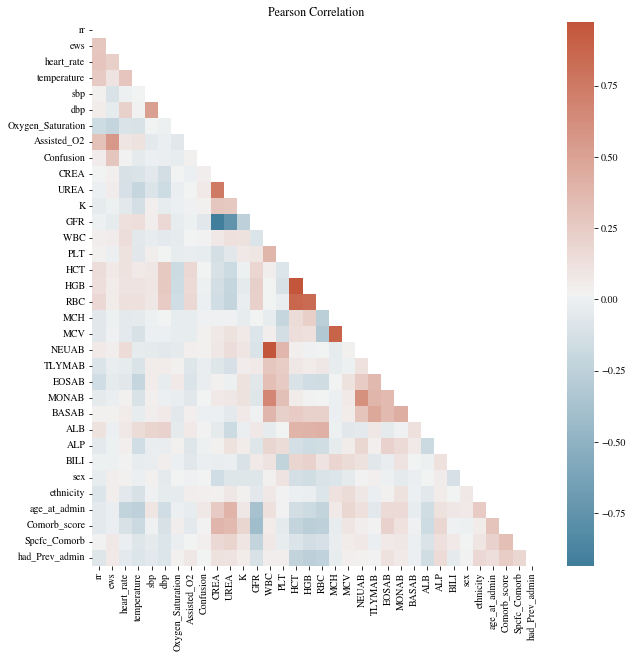

In [16]:
########################################################################
# PLOT CORRELATION MATRIX
########################################################################
f, ax = plt.subplots(figsize=(10, 10))
# Generate a mask for upper traingle#
mask = np.triu(np.ones_like(corr, dtype=bool))
#import matplotlib
#matplotlib.rcParams['mathtext.fontset'] = 'cm'
# Configure a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap
sns.heatmap(corr, mask = mask, cmap=cmap)
plt.savefig('Pearson Correlation_STA.png', transparent = True, bbox_inches = "tight")
plt.title('Pearson Correlation')
plt.show()

# 3. Logistic Regression to asses significance

### Data to process

In [17]:
X_data_norm.head(5)
df_results = pd.DataFrame()

### 3.1 Individual variable significance

In [18]:
from scipy import stats
from statsmodels.stats.weightstats import ztest as ztest
from scipy.stats import chi2_contingency


In [19]:
########################################################################
# VARIABLE INDIVIDUAL SIGNIFICANCE
########################################################################
p_norm_test = []
idx_0 = X_data[X_data['Mortality'] == 0].index
idx_1 = X_data[X_data['Mortality'] == 1].index
for idx, feat1 in enumerate(feat_list):
    p = ''
    x_0 = X_data_norm.loc[idx_0][feat1]
    x_1 = X_data_norm.loc[idx_1][feat1]
    type1  = data_types[feat1]
    
    if (type1 == 'Continuous') :
        sts, p = stats.ttest_ind(x_0, x_1)
    elif (type1 == 'Binary'):
        
        sts, p1 = ztest(x_0, x_1, value=0) 
        contigency = pd.crosstab(index=X_data['Mortality'], columns=X_data[feat1], margins=True)
        contigency = contigency.drop(columns=['All'], index =['All'])
        c, p, dof, expected = chi2_contingency(contigency)
        print(feat1, '{:3f}'.format(p), '{:3f}'.format(p1))
    elif (type1 == 'Categorical'):
        sts, p = stats.kruskal(x_0, x_1)
        print(feat1, '{:3f}'.format(p))
        
    p_norm_test.append(p)

ews 0.001213
Assisted_O2 0.455324 0.439526
Confusion 0.000449 0.000370
sex 0.003414 0.003123
ethnicity 0.000217
Spcfc_Comorb 0.000000 0.000000
had_Prev_admin 0.000000 0.000000


In [20]:
########################################################################
# RESULTS
########################################################################
df_results['type'] = [data_types[feat1] for feat1 in feat_list]
df_results['pval_Indiv'] = p_norm_test
df_results = df_results.set_index([feat_list])
display(df_results)

,type,pval_Indiv
rr,Continuous,0.82931
ews,Categorical,0.00121
heart_rate,Continuous,0.00034
temperature,Continuous,0.00000
sbp,Continuous,0.00004
dbp,Continuous,0.00000
Oxygen_Saturation,Continuous,0.04028
Assisted_O2,Binary,0.45532
Confusion,Binary,0.00045
CREA,Continuous,0.00000


### 3.2 Multivariate Logistic Regression

In [21]:
import statsmodels.api as sm

In [22]:
X_train = X_data_norm
y_train = X_data['Mortality']
logit_model=sm.Logit(y_train,X_train)
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.494903
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              Mortality   No. Observations:                 7892
Model:                          Logit   Df Residuals:                     7858
Method:                           MLE   Df Model:                           33
Date:                Thu, 20 Jul 2023   Pseudo R-squ.:                  0.1135
Time:                        13:50:32   Log-Likelihood:                -3905.8
converged:                       True   LL-Null:                       -4405.8
Covariance Type:            nonrobust   LLR p-value:                9.426e-189
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
rr                    0.0479      0.032      1.489      0.137      -0.015       0.111
ews     

In [23]:
df_results['pval_logR'] = result.pvalues.tolist()
df_results['coef_logR'] = result.params.tolist()

### 3.3 Lasso Regression Original Data

In [24]:
X_data[feat_list].head(3)

,rr,ews,heart_rate,temperature,sbp,dbp,Oxygen_Saturation,Assisted_O2,Confusion,CREA,...,BASAB,ALB,ALP,BILI,sex,ethnicity,age_at_admin,Comorb_score,Spcfc_Comorb,had_Prev_admin
0,17.00000,2,102.00000,36.50000,148.00000,80.00000,95.00000,0.00000,0,75.00000,...,0.03000,34.00000,69.00000,8.00000,1,0,69,0,1,1.00000
144,22.00000,7,95.00000,39.80000,113.00000,68.00000,96.00000,1.00000,0,111.00000,...,0.02000,40.00000,152.00000,13.00000,-1,0,77,2,1,0.00000
288,17.00000,0,69.00000,37.20000,148.00000,83.00000,99.00000,0.00000,0,227.00000,...,0.01333,27.00000,93.00000,1.99850,-1,9,60,2,0,1.00000


In [25]:
import regressors
from sklearn.linear_model import LassoCV
from regressors import stats

In [26]:
X_train = X_data[feat_list]
y_train = X_data['Mortality']

In [27]:
lasso_reg = LassoCV(cv = 5)
lasso_reg.fit(X_train, y_train)

regressors.stats.summary(lasso_reg, X_train, y_train)

Residuals:
     Min      1Q  Median      3Q     Max
-0.29080 0.15090 0.24910 0.34200 0.75290


Coefficients:
            Estimate  Std. Error   t value  p value
_intercept   0.98960     0.33758   2.93140  0.00338
x1           0.00033     0.00112   0.29430  0.76854
x2           0.00554     0.00275   2.01220  0.04423
x3           0.00029     0.00023   1.25240  0.21047
x4          -0.01815     0.00377  -4.81990  0.00000
x5          -0.00051     0.00021  -2.43350  0.01498
x6           0.00040     0.00035   1.15870  0.24662
x7          -0.00091     0.00094  -0.96480  0.33468
x8          -0.00000     0.01180  -0.00000  1.00000
x9           0.00000     0.01847   0.00000  1.00000
x10         -0.00020     0.00010  -2.12980  0.03322
x11          0.00849     0.00127   6.70790  0.00000
x12         -0.00000     0.00697  -0.00000  1.00000
x13          0.00000     0.00038   0.00000  1.00000
x14         -0.00020     0.00135  -0.14960  0.88108
x15         -0.00011     0.00003  -3.16970  0.00153
x16    

In [28]:
p_vals_lasso = list(regressors.stats.coef_pval(lasso_reg, X_train, y_train))[1:]
df_results['pval_Lasso_org'] = p_vals_lasso

### 3.4 Lasso Regression Normalised Data

In [29]:
X_train = X_data[feat_list]
y_train = X_data['Mortality']

In [30]:
lasso_reg_norm = LassoCV(cv = 5)
lasso_reg_norm.fit(X_train, y_train)

regressors.stats.summary(lasso_reg_norm, X_train, y_train)

Residuals:
     Min      1Q  Median      3Q     Max
-0.29080 0.15090 0.24910 0.34200 0.75290


Coefficients:
            Estimate  Std. Error   t value  p value
_intercept   0.98960     0.33758   2.93140  0.00338
x1           0.00033     0.00112   0.29430  0.76854
x2           0.00554     0.00275   2.01220  0.04423
x3           0.00029     0.00023   1.25240  0.21047
x4          -0.01815     0.00377  -4.81990  0.00000
x5          -0.00051     0.00021  -2.43350  0.01498
x6           0.00040     0.00035   1.15870  0.24662
x7          -0.00091     0.00094  -0.96480  0.33468
x8          -0.00000     0.01180  -0.00000  1.00000
x9           0.00000     0.01847   0.00000  1.00000
x10         -0.00020     0.00010  -2.12980  0.03322
x11          0.00849     0.00127   6.70790  0.00000
x12         -0.00000     0.00697  -0.00000  1.00000
x13          0.00000     0.00038   0.00000  1.00000
x14         -0.00020     0.00135  -0.14960  0.88108
x15         -0.00011     0.00003  -3.16970  0.00153
x16    

In [31]:
p_vals_lasso_norm = list(regressors.stats.coef_pval(lasso_reg_norm, X_train, y_train))[1:]
df_results['pval_Lasso_norm'] = p_vals_lasso_norm

In [32]:
regressors.stats.coef_se(lasso_reg_norm, X_train, y_train)

array([3.37583699e-01, 1.11868419e-03, 2.75205468e-03, 2.33172873e-04,
       3.76621827e-03, 2.08574987e-04, 3.48309124e-04, 9.42949382e-04,
       1.18008256e-02, 1.84740471e-02, 9.56705676e-05, 1.26504716e-03,
       6.97241048e-03, 3.74912978e-04, 1.35424713e-03, 3.52204965e-05,
       9.59069118e-01, 2.59185021e-04, 3.58458296e-02, 4.85325499e-03,
       9.33953905e-04, 2.36322693e-03, 6.80908194e-03, 3.43077129e-02,
       2.18533059e-02, 1.56989850e-01, 9.67552597e-04, 1.03807251e-04,
       5.08058591e-04, 5.25019610e-03, 1.91329638e-03, 3.02606381e-04,
       2.86969316e-03, 9.93904332e-03, 9.82802594e-03])

### 3.5 Ridge Linear Regression

In [33]:
from sklearn.linear_model import RidgeCV
from regressors import stats

In [34]:
X_train = X_data_norm
y_train = X_data['Mortality']

In [35]:
rr_scaled = RidgeCV(cv =5)
rr_scaled.fit(X_train, y_train)

regressors.stats.summary(rr_scaled, X_train, y_train)

Residuals:
     Min      1Q  Median      3Q     Max
-0.32390 0.14550 0.24850 0.34580 0.95400


Coefficients:
            Estimate  Std. Error   t value  p value
_intercept   0.02863     0.02716   1.05400  0.29191
x1           0.00581     0.00500   1.16230  0.24513
x2           0.75639     0.17606   4.29630  0.00002
x3           0.00716     0.00512   1.39890  0.16189
x4          -0.02196     0.00504  -4.35260  0.00001
x5          -0.01062     0.00537  -1.97730  0.04804
x6           0.00598     0.00552   1.08230  0.27913
x7          -0.00424     0.00470  -0.90290  0.36659
x8           0.00005     0.00963   0.00480  0.99614
x9           0.00963     0.01716   0.56130  0.57463
x10         -0.01717     0.01011  -1.69900  0.08937
x11          0.04948     0.00731   6.76620  0.00000
x12         -0.00186     0.00486  -0.38240  0.70217
x13         -0.00317     0.00979  -0.32360  0.74623
x14         -0.00393     0.00954  -0.41140  0.68079
x15         -0.01111     0.00533  -2.08680  0.03694
x16    

In [36]:
p_vals_ridge = list(regressors.stats.coef_pval(rr_scaled, X_train, y_train))[1:]
df_results['pval_Ridge'] = p_vals_ridge

# # DISPLAY RESULTS
###########################################
#display(df_results)
df_results = df_results.copy()
df_results['idx'] = feat_list
df_results = df_results.set_index('idx')
df_results['LogR_sig'] = df_results['pval_logR'].apply(lambda x: 0 if x > 0.099 else 0.5 if x > 0.05 else 1)
df_results

In [37]:
########################################### 
display(df_results) 
df_results = df_results.copy() 
df_results['idx'] = feat_list 
df_results = df_results.set_index('idx') 
df_results['LogR_sig'] = df_results['pval_logR'].apply(lambda x: 0 if x > 0.099 else 0.5 if x > 0.05 else 1) 
df_results

,type,pval_Indiv,pval_logR,coef_logR,pval_Lasso_org,pval_Lasso_norm,pval_Ridge
rr,Continuous,0.82931,0.13655,0.04785,0.76854,0.76854,0.24513
ews,Categorical,0.00121,0.58225,-0.42145,0.04423,0.04423,0.00002
heart_rate,Continuous,0.00034,0.04397,0.06418,0.21047,0.21047,0.16189
temperature,Continuous,0.00000,0.00003,-0.13400,0.00000,0.00000,0.00001
sbp,Continuous,0.00004,0.07048,-0.06169,0.01498,0.01498,0.04804
dbp,Continuous,0.00000,0.44644,0.02657,0.24662,0.24662,0.27913
Oxygen_Saturation,Continuous,0.04028,0.02479,-0.06365,0.33468,0.33468,0.36659
Assisted_O2,Binary,0.45532,0.56359,0.03572,1.00000,1.00000,0.99614
Confusion,Binary,0.00045,0.29701,0.10523,1.00000,1.00000,0.57463
CREA,Continuous,0.00000,0.23240,-0.07962,0.03322,0.03322,0.08937


,type,pval_Indiv,pval_logR,coef_logR,pval_Lasso_org,pval_Lasso_norm,pval_Ridge,LogR_sig
idx,,,,,,,,
rr,Continuous,0.82931,0.13655,0.04785,0.76854,0.76854,0.24513,0.00000
ews,Categorical,0.00121,0.58225,-0.42145,0.04423,0.04423,0.00002,0.00000
heart_rate,Continuous,0.00034,0.04397,0.06418,0.21047,0.21047,0.16189,1.00000
temperature,Continuous,0.00000,0.00003,-0.13400,0.00000,0.00000,0.00001,1.00000
sbp,Continuous,0.00004,0.07048,-0.06169,0.01498,0.01498,0.04804,0.50000
dbp,Continuous,0.00000,0.44644,0.02657,0.24662,0.24662,0.27913,0.00000
Oxygen_Saturation,Continuous,0.04028,0.02479,-0.06365,0.33468,0.33468,0.36659,1.00000
Assisted_O2,Binary,0.45532,0.56359,0.03572,1.00000,1.00000,0.99614,0.00000
Confusion,Binary,0.00045,0.29701,0.10523,1.00000,1.00000,0.57463,0.00000


In [38]:
dict_labels = {'rr':'Respiratory rate','ews':'EWS','heart_rate':'Heart rate','temperature':'Temperature',
               'sbp':'Systolic bp','dbp':'Diastolic bp','Oxygen_Saturation':'Oxygen Saturation','Assisted_O2':'Assisted O2',
               'Confusion':'Confusion','CREA':'Creatinine','UREA':'Urea','K':'Potassium', 'GFR':'GFR','WBC':'WBC',
               'PLT':'Platelets','HCT':'HCT','HGB':'Haemoglobin','RBC':'RBC','MCH':'MCH','MCV':'MCV','NEUAB':'Neutrophil Ab',
               'TLYMAB':'T-lymphocite Ab','EOSAB':'EOS Ab','MONAB':'Monocyte Ab','BASAB':'Anti Basophil Ab','ALB':'Albumin',
               'ALP':'Alk. Phosphate','BILI':'Bilirubin','sex':'Sex','ethnicity':'Ethnicity','had_Prev_admin':'Prev. admission',
               'age_at_admin':'Age at admission','Comorb_score':'Charlson comorbid.','Spcfc_Comorb':'Resp. Comorbidity'}

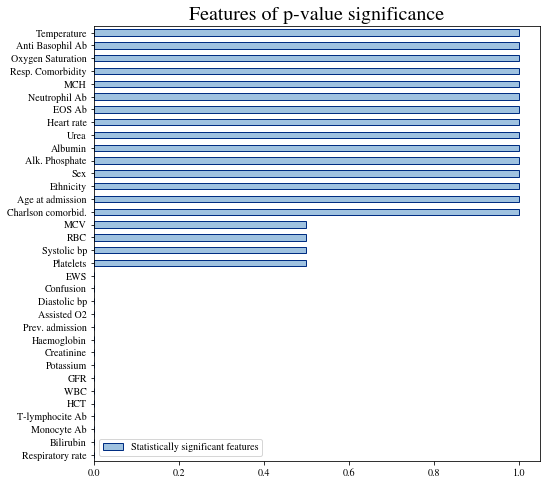

In [39]:
matplotlib.rcParams['mathtext.fontset'] = 'cm'
df_results['LogR_sig'].sort_values(ascending = True).plot.barh(figsize=(8, 8), edgecolor='#002D82', color='#9fc2e0',
                                                               label = "Statistically significant features")
plt.legend()
plt.ylabel('')
ordered_label = [dict_labels[feat] for feat in df_results['LogR_sig'].sort_values(ascending = True).index]
plt.yticks(range(len(df_results['LogR_sig'].index.tolist())), ordered_label)

plt.title('Features of p-value significance', fontsize = 20)
#plt.savefig('Feature_selection_STA.png', transparent = True, bbox_inches = "tight")
plt.show()

# _______________________________________

# 4. Feature Importance

#### Using Random Forrest, Decision Trees and XGBoost models
[Explanation of importance calculus](https://towardsdatascience.com/the-mathematics-of-decision-trees-random-forest-and-feature-importance-in-scikit-learn-and-spark-f2861df67e3)

In [40]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn import svm

In [41]:
X_train = X_data_norm
y_train = X_data['Mortality']

In [42]:
row = []

y = np.array(X_data['Mortality'])
#X = np.array(X_data_norm)
X = X_data[feat_list]
#model = DecisionTreeRegressor()
#model = RandomForestRegressor()

# fit the model DTree
model_DTree  = DecisionTreeRegressor()
model_DTree.fit(X, y)
import_DTree = model_DTree.feature_importances_

# fit the model RFor
model_RFor  = RandomForestRegressor()
model_RFor.fit(X, y)
import_RFor = model_RFor.feature_importances_

# fit the model XGB
model_XGB  =  XGBRegressor()
model_XGB.fit(X, y)
import_XGB = model_XGB.feature_importances_

for i,v in enumerate(import_DTree):
    row.append((v, import_RFor[i], import_XGB[i]))
row = pd.DataFrame(row, columns = ['import_DT', 'import_RF', 'import_XGB'], index = feat_list)
display(row)

,import_DT,import_RF,import_XGB
rr,0.02663,0.02290,0.01110
ews,0.01274,0.01717,0.01287
heart_rate,0.04536,0.03420,0.01929
temperature,0.03361,0.03369,0.02555
sbp,0.03720,0.03372,0.02259
dbp,0.02584,0.03457,0.02132
Oxygen_Saturation,0.02007,0.02206,0.02634
Assisted_O2,0.00464,0.00325,0.02225
Confusion,0.00369,0.00279,0.03216
CREA,0.03380,0.03416,0.02319


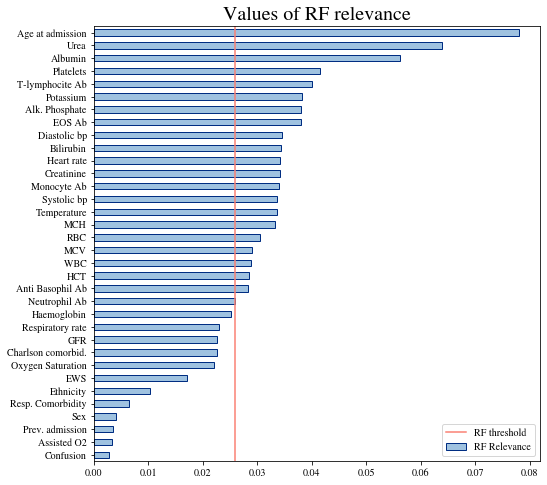

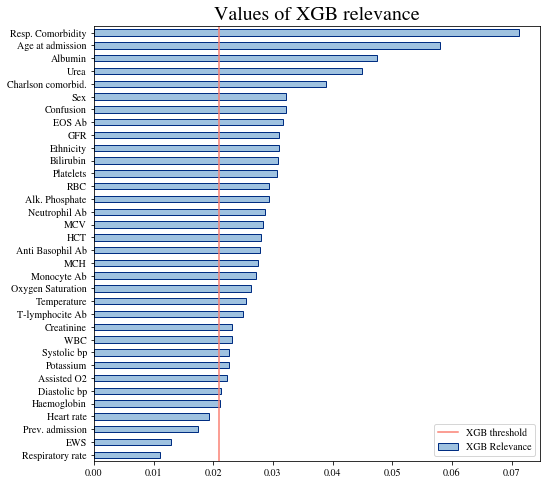

In [43]:
#row['import_DT'].sort_values(ascending = True).plot.barh(figsize=(8, 10))
#plt.axvline(x = 0.026, color = 'r', linestyle = '-')
#plt.savefig('Feature_selection_DT.png', transparent = True, bbox_inches = "tight")
#plt.show()
matplotlib.rcParams['mathtext.fontset'] = 'cm'
row['import_RF'].sort_values(ascending = True).plot.barh(figsize=(8, 8), label = "RF Relevance", color='#9fc2e0', 
                                                         edgecolor='#002D82')
ordered_label = [dict_labels[feat] for feat in row['import_RF'].sort_values(ascending = True).index]

plt.axvline(x = 0.026, linestyle = '-', label = "RF threshold", color = '#FA8072')
plt.legend()
plt.yticks(range(len(row['import_RF'].sort_values(ascending = True).index)), ordered_label)
plt.title('Values of RF relevance', fontsize = 20)
plt.savefig('Feature_selection_RF.png', transparent = True, bbox_inches = "tight")
plt.show()

row['import_XGB'].sort_values(ascending = True).plot.barh(figsize=(8, 8), label = "XGB Relevance", color='#9fc2e0', 
                                                          edgecolor='#002D82')
ordered_label = [dict_labels[feat] for feat in row['import_XGB'].sort_values(ascending = True).index]
plt.yticks(range(len(row['import_RF'].index)), ordered_label)
plt.axvline(x = 0.021, linestyle = '-', label = "XGB threshold", color = '#FA8072')
plt.legend()
plt.title('Values of XGB relevance', fontsize = 20)
plt.savefig('Feature_selection_XGB.png', transparent = True, bbox_inches = "tight")
plt.show()

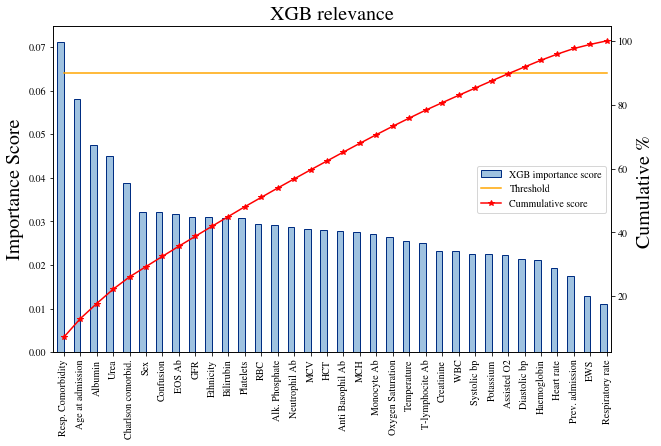

In [44]:

df_ordered = row['import_XGB'].sort_values(ascending = False).to_frame()
df_ordered['accum_per'] = 100*(df_ordered.cumsum() / df_ordered.sum())
fig = plt.figure(figsize = (10,6)) # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['mathtext.fontset'] = 'cm'
#

width = 0.4
ax2.plot(range(len(df_ordered['import_XGB'])), len(df_ordered['import_XGB'])*[90], color = '#FFA500', label = 'Threshold')
df_ordered['import_XGB'].plot.bar(label = "XGB importance score", color='#9fc2e0', edgecolor='#002D82',
                                  ax=ax, width=width, position=1)
df_ordered['accum_per'].plot( label = "Cummulative score", color= 'r', marker ='*', ax=ax2)

ordered_label = [dict_labels[feat] for feat in row['import_XGB'].sort_values(ascending = False).index]
plt.xticks(range(len(ordered_label)), ordered_label)

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc= 'center right')
plt.title(r'XGB relevance', fontsize = 20)
ax.set_ylabel('Importance Score', fontsize = 20)
ax2.set_ylabel('Cumulative % ', fontsize = 20)
plt.xticks(range(len(ordered_label)), ordered_label)
plt.savefig('Feature_selection_XGB_2.png', transparent = True, bbox_inches = "tight")
plt.show()

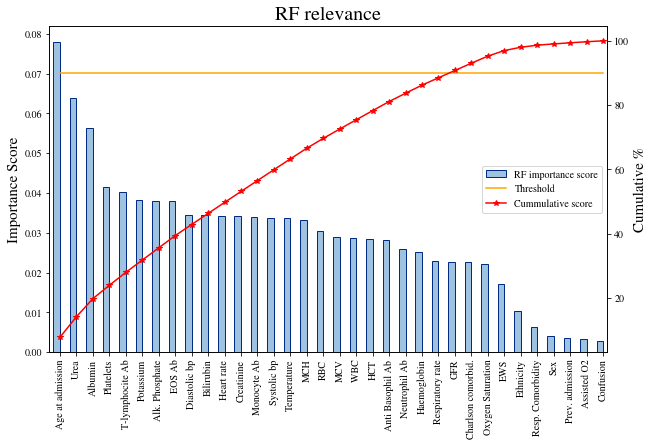

In [45]:
df_ordered = row['import_RF'].sort_values(ascending = False).to_frame()
df_ordered['accum_per'] = 100*(df_ordered.cumsum() / df_ordered.sum())

fig = plt.figure(figsize = (10,6)) # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.4
ax2.plot(range(len(df_ordered['import_RF'])), len(df_ordered['import_RF'])*[90], color = '#FFA500', label = 'Threshold')
df_ordered['import_RF'].plot.bar(label = "RF importance score", color='#9fc2e0', edgecolor='#002D82',
                                  ax=ax, width=width, position=1)
df_ordered['accum_per'].plot( label = "Cummulative score", color= 'r', marker ='*', ax=ax2)

ordered_label = [dict_labels[feat] for feat in row['import_RF'].sort_values(ascending = False).index]
plt.xticks(range(len(ordered_label)), ordered_label)

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc= 'center right')
plt.title('RF relevance', fontsize = 20)
ax.set_ylabel('Importance Score', fontsize = 15)
ax2.set_ylabel('Cumulative %', fontsize = 15)
plt.savefig('Feature_selection_RF_2.png', transparent = True, bbox_inches = "tight")
plt.show()

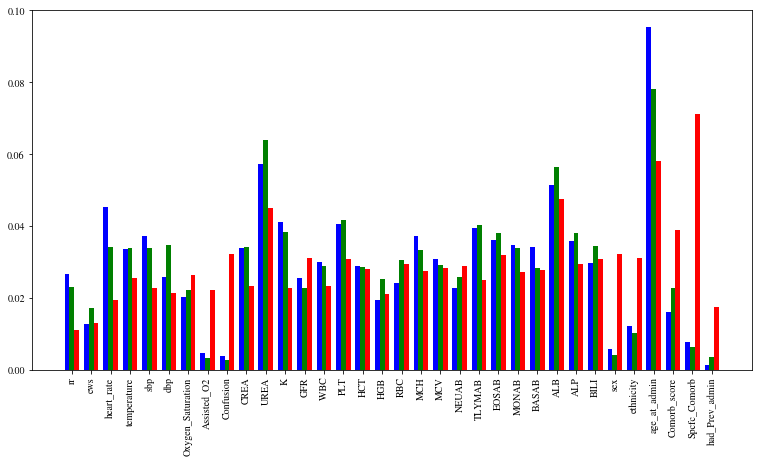

In [46]:

X = np.arange(len(feat_list))

fig = plt.figure(figsize = (10,5))
ax  = fig.add_axes([0,0,1,1])


ax.bar(X - 0.25, row['import_DT'],  color = 'b', width = 0.25, label ='DT')
ax.bar(X + 0.00, row['import_RF'],  color = 'g', width = 0.25, label='RF')
ax.bar(X + 0.25, row['import_XGB'], color = 'r', width = 0.25, label = 'XGB')

ax.set_xticks(np.arange(len(feat_list)))
ax.set_xticklabels(feat_list, rotation = 90)
plt.savefig('Feature_selection_16_18.png', transparent = True, bbox_inches = "tight")
plt.show()

# Description of Variables

In [47]:
import math 
print('Continuous variables')
df_descrip    = []
idx_cont_cols = [i for i, name in enumerate(feat_list) if data_types[name] == 'Continuous']
X = np.asarray(X_data[X_data['Mortality']==0][feat_list])

for idx in idx_cont_cols:
    m      = X[:, idx].mean()
    s      = X[:, idx].std()
    ci95   = ['{:.2f}'.format(m - 1.95*s/math.sqrt(len(X))),'{:.2f}'.format(m + 1.95*s/math.sqrt(len(X)))]
    mm_rng = ['{:.2f}'.format(X[:, idx].min()), '{:.2f}'.format(X[:,idx].max())]
    row    = [feat_list[idx]] + ['{:.2f}'.format(m), '{:.2f}'.format(s), '{:.2f}'.format(np.median(X[:, idx]))
                                  , ci95, mm_rng]
    df_descrip.append(row)  
    
df_descrip_0 = pd.DataFrame (df_descrip, columns = ['variable','mean', 'st_dev', 'median', 'conf-int', 'Min-Max rng'])
display(df_descrip_0)

#___________________________________________________________________________________________________
#___________________________________________________________________________________________________
df_descrip    = []
X = np.asarray(X_data[X_data['Mortality']==1][feat_list])

for idx in idx_cont_cols:
    m      = X[:, idx].mean()
    s      = X[:, idx].std()
    ci95   = ['{:.2f}'.format(m - 1.95*s/math.sqrt(len(X))),'{:.2f}'.format(m + 1.95*s/math.sqrt(len(X)))]
    mm_rng = ['{:.2f}'.format(X[:, idx].min()), '{:.2f}'.format(X[:,idx].max())]
    row    = [feat_list[idx]] + ['{:.2f}'.format(m), '{:.2f}'.format(s), '{:.2f}'.format(np.median(X[:, idx]))
                                  , ci95, mm_rng]
    df_descrip.append(row)  
    
df_descrip_1 = pd.DataFrame (df_descrip, columns = ['variable','mean', 'st_dev', 'median', 'conf-int', 'Min-Max rng'])
display(df_descrip_1)

Continuous variables


,variable,mean,st_dev,median,conf-int,Min-Max rng
0,rr,21.51,5.00,20.00,"[21.38, 21.63]","[9.00, 40.00]"
1,heart_rate,90.57,20.27,89.00,"[90.06, 91.08]","[27.00, 160.00]"
2,temperature,37.11,0.90,37.00,"[37.09, 37.13]","[30.00, 41.50]"
3,sbp,128.57,23.18,127.00,"[127.98, 129.16]","[60.00, 200.00]"
4,dbp,75.12,15.58,74.00,"[74.73, 75.52]","[40.00, 120.00]"
5,Oxygen_Saturation,95.83,3.16,96.00,"[95.75, 95.91]","[61.00, 100.00]"
6,CREA,105.27,61.40,87.00,"[103.72, 106.82]","[20.86, 330.00]"
7,UREA,8.48,5.63,6.80,"[8.34, 8.62]","[1.40, 30.00]"
8,K,4.28,0.68,4.20,"[4.26, 4.30]","[2.20, 7.00]"
9,GFR,66.55,22.77,72.00,"[65.97, 67.12]","[20.00, 90.00]"


,variable,mean,st_dev,median,conf-int,Min-Max rng
0,rr,21.48,5.03,20.00,"[21.26, 21.70]","[11.00, 40.00]"
1,heart_rate,88.65,21.18,87.00,"[87.72, 89.59]","[20.00, 160.00]"
2,temperature,36.82,0.92,36.70,"[36.78, 36.86]","[30.00, 41.70]"
3,sbp,126.06,23.92,124.00,"[125.00, 127.12]","[60.00, 200.00]"
4,dbp,73.13,16.59,71.00,"[72.40, 73.86]","[40.00, 120.00]"
5,Oxygen_Saturation,95.65,3.56,96.00,"[95.50, 95.81]","[63.00, 100.00]"
6,CREA,125.63,72.55,102.75,"[122.43, 128.84]","[23.57, 330.00]"
7,UREA,11.36,6.94,9.40,"[11.05, 11.66]","[1.58, 30.00]"
8,K,4.38,0.77,4.30,"[4.34, 4.41]","[2.00, 7.00]"
9,GFR,57.57,23.93,57.00,"[56.51, 58.63]","[20.00, 90.00]"


In [48]:
import math 
print('Binary variables')
df_descrip    = []
idx_cont_cols = [i for i, name in enumerate(feat_list) if data_types[name] == 'Binary']
#X = np.asarray(X_data[X_data['Mortality']==0][feat_list])
X = X_data[X_data['Mortality']==0][feat_list]

for idx in idx_cont_cols:
    name    = feat_list[idx]
    count_1 = len(X[X[name]==1])
    percent = 100* count_1/len(X[name])
    row = [feat_list[idx], count_1, '{:.2f}'.format( percent)]
    df_descrip.append(row)  
    
df_descrip = pd.DataFrame (df_descrip, columns = ['variable','count', 'percent'])
display(df_descrip)

#___________________________________________________________________________________________________
#___________________________________________________________________________________________________


df_descrip_1   = []
#X = np.asarray(X_data[X_data['Mortality']==0][feat_list])
X = X_data[X_data['Mortality']==1][feat_list]

for idx in idx_cont_cols:
    name    = feat_list[idx]
    count_1 = len(X[X[name]==1])
    percent = 100* count_1/len(X[name])
    row = [feat_list[idx], count_1, '{:.2f}'.format( percent)]
    df_descrip_1.append(row)  
    
df_descrip_1 = pd.DataFrame (df_descrip_1, columns = ['variable','count', 'percent'])
display(df_descrip_1)

Binary variables


,variable,count,percent
0,Assisted_O2,2465,41.44
1,Confusion,427,7.18
2,sex,2725,45.81
3,Spcfc_Comorb,2670,44.89
4,had_Prev_admin,3044,51.18


,variable,count,percent
0,Assisted_O2,825,42.44
1,Confusion,188,9.67
2,sex,816,41.98
3,Spcfc_Comorb,1206,62.04
4,had_Prev_admin,1186,61.01


In [49]:
import math 
print('Categorical variables')
df_descrip    = []
idx_cont_cols = [i for i, name in enumerate(feat_list) if data_types[name] == 'Categorical']
#X = np.asarray(X_data[X_data['Mortality']==0][feat_list])
X = np.asarray(X_data[X_data['Mortality']==0][feat_list])

for idx in idx_cont_cols:
    name    = feat_list[idx]
    median  = np.median(X[:, idx])
    iqr     = np.percentile(X[:, idx], [75 ,25])
    row = [feat_list[idx], median, iqr]
    df_descrip.append(row)  
    
df_descrip = pd.DataFrame (df_descrip, columns = ['variable','median', 'iqr'])
display(df_descrip)

#___________________________________________________________________________________________________
#___________________________________________________________________________________________________


df_descrip_1   = []
#X = np.asarray(X_data[X_data['Mortality']==0][feat_list])
X = np.asarray(X_data[X_data['Mortality']==1][feat_list])

for idx in idx_cont_cols:
    name    = feat_list[idx]
    median  = np.median(X[:, idx])
    iqr     = np.percentile(X[:, idx], [75 ,25])
    row = [feat_list[idx], median, iqr]
    df_descrip_1.append(row)  
    
df_descrip_1 = pd.DataFrame (df_descrip_1, columns = ['variable','median', 'iqr'])
display(df_descrip_1)

Categorical variables


,variable,median,iqr
0,ews,3.00000,"[6.0, 2.0]"
1,ethnicity,0.00000,"[1.0, 0.0]"


,variable,median,iqr
0,ews,4.00000,"[6.0, 2.0]"
1,ethnicity,0.00000,"[1.0, 0.0]"


In [50]:
print(len(X_data[X_data['Mortality']==0][feat_list]))
print(len(X_data[X_data['Mortality']==1][feat_list]))

5948
1944


In [51]:
len(df_eobs['admission_id'].unique())

7892

In [52]:
admins_data   = X_data['admission_id'].unique().tolist()
patients_data = df_admissions[df_admissions['admission_id'].isin(admins_data)]['patient_id'].unique().tolist()
print(len(admins_data))
print(len(patients_data))

7892
7236


In [53]:
########################################################################
# KOLMOGOROV-SMIRNOV TEST OF NORMALITY
########################################################################
from scipy import stats
df_norm_test = []
for idx, feat1 in enumerate(feat_list):
    x  = X_data_norm[feat1]
    x2 = X_data[feat1]
    cff, p  = stats.kstest(x, 'norm')
    cff, p2 = stats.kstest(x2, 'norm')
    df_norm_test.append([feat1, p, p2])
df_norm_test = pd.DataFrame(df_norm_test, columns = ['feature', 'p_norm','p_raw'])
display(df_norm_test)

,feature,p_norm,p_raw
0,rr,0.00000,0.00000
1,ews,0.00000,0.00000
2,heart_rate,0.00000,0.00000
3,temperature,0.00000,0.00000
4,sbp,0.00000,0.00000
5,dbp,0.00000,0.00000
6,Oxygen_Saturation,0.00000,0.00000
7,Assisted_O2,0.00000,0.00000
8,Confusion,0.00000,0.00000
9,CREA,0.00000,0.00000


In [54]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [55]:
X_train = X_data_norm
y_train = X_data['Mortality']

In [56]:
row_ = []

y = np.array(X_data['Mortality'])
#X = np.array(X_data_norm)
X = X_data[feat_list]
#model = DecisionTreeRegressor()
#model = RandomForestRegressor()

# fit the model DTree
model_DTree  = DecisionTreeRegressor()
model_DTree.fit(X, y)
import_DTree = model_DTree.feature_importances_

# fit the model RFor
model_RFor  = RandomForestClassifier()
model_RFor.fit(X, y)
import_RFor = model_RFor.feature_importances_

# fit the model RFor
model_RFor_2  = RandomForestClassifier(criterion='entropy')
model_RFor_2.fit(X, y)
import_RFor_2 = model_RFor_2.feature_importances_

# fit the model XGB
model_XGB  =  XGBClassifier()
model_XGB.fit(X, y)
import_XGB = model_XGB.feature_importances_

for i,v in enumerate(import_DTree):
    row_.append((v, import_RFor[i], import_RFor_2[i], import_XGB[i]))
row_ = pd.DataFrame(row_, columns = ['import_DT', 'import_RF', 'import_RF_2', 'import_XGB'], index = feat_list)
display(row_)

,import_DT,import_RF,import_RF_2,import_XGB
rr,0.02405,0.02313,0.02247,0.02534
ews,0.01236,0.02036,0.01985,0.02055
heart_rate,0.04380,0.03268,0.03215,0.02235
temperature,0.02864,0.03463,0.03329,0.02831
sbp,0.03995,0.03192,0.03318,0.02744
dbp,0.02950,0.03242,0.03140,0.02514
Oxygen_Saturation,0.01737,0.02319,0.02295,0.02334
Assisted_O2,0.00565,0.00464,0.00449,0.02279
Confusion,0.00404,0.00361,0.00299,0.03310
CREA,0.03806,0.03870,0.03873,0.02653


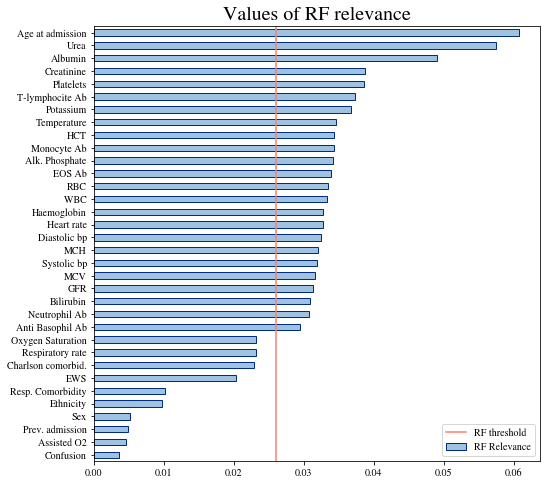

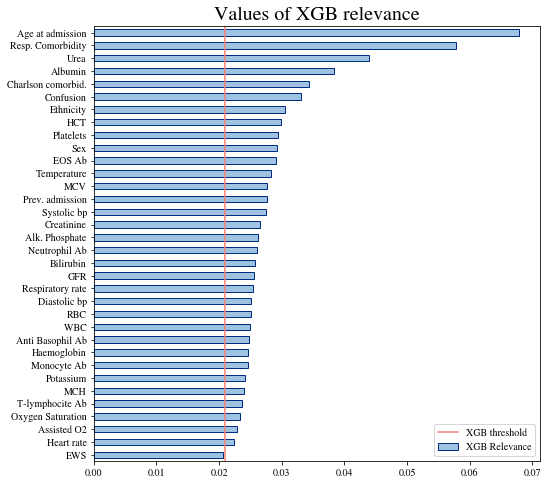

In [57]:
#row['import_DT'].sort_values(ascending = True).plot.barh(figsize=(8, 10))
#plt.axvline(x = 0.026, color = 'r', linestyle = '-')
#plt.savefig('Feature_selection_DT.png', transparent = True, bbox_inches = "tight")
#plt.show()

row_['import_RF'].sort_values(ascending = True).plot.barh(figsize=(8, 8), label = "RF Relevance", color='#9fc2e0', 
                                                         edgecolor='#002D82')
ordered_label = [dict_labels[feat] for feat in row_['import_RF'].sort_values(ascending = True).index]

plt.axvline(x = 0.026, linestyle = '-', label = "RF threshold", color = '#FA8072')
plt.legend()
plt.yticks(range(len(row_['import_RF'].sort_values(ascending = True).index)), ordered_label)
plt.title('Values of RF relevance', fontsize = 20)
#plt.savefig('Feature_selection_RF.png', transparent = True, bbox_inches = "tight")
plt.show()

row_['import_XGB'].sort_values(ascending = True).plot.barh(figsize=(8, 8), label = "XGB Relevance", color='#9fc2e0', 
                                                          edgecolor='#002D82')
ordered_label = [dict_labels[feat] for feat in row_['import_XGB'].sort_values(ascending = True).index]
plt.yticks(range(len(row_['import_XGB'].sort_values(ascending = True).index)), ordered_label)
plt.axvline(x = 0.021, linestyle = '-', label = "XGB threshold", color = '#FA8072')
plt.legend()
plt.title('Values of XGB relevance', fontsize = 20)
#plt.savefig('Feature_selection_XGB.png', transparent = True, bbox_inches = "tight")
plt.show()